### Import des modules 

In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

En règle générale : On utilise la méthode .apply() de Pandas pour créer une nouvelle colonne à partir d'une colonne existante. N'hésitez pas à regarder les exemples dans les chapitres de cours donnés en ressource

In [244]:
building_consumption = pd.read_csv("../assets/building_consumption_post_EDA.csv")
print(	
	(
    building_consumption["ListOfAllPropertyUseTypes"].isna()
    | (building_consumption["ListOfAllPropertyUseTypes"].str.strip() == "")
).sum())
building_consumption.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1539 non-null   int64  
 1   DataYear                         1539 non-null   int64  
 2   BuildingType                     1539 non-null   object 
 3   PrimaryPropertyType              1539 non-null   object 
 4   PropertyName                     1539 non-null   object 
 5   Address                          1539 non-null   object 
 6   City                             1539 non-null   object 
 7   State                            1539 non-null   object 
 8   ZipCode                          1526 non-null   float64
 9   TaxParcelIdentificationNumber    1539 non-null   object 
 10  CouncilDistrictCode              1539 non-null   int64  
 11  Neighborhood                     1539 non-null   object 
 12  Latitude          

## 1. Nouvelle feature sur le type d'usage: NumberOfUseTypes

### A partir de la liste des usages, compter le nombre d'usages différents pour chaque bâtiment


In [245]:
# Créer NumberOfUseTypes à partir de ListOfAllPropertyUseTypes
building_consumption["NumberOfUseTypes"] = (
    building_consumption["ListOfAllPropertyUseTypes"]
    .fillna("")
    .apply(lambda x: len(x.split(",")) if x else 0)
)

# Vérification rapide
building_consumption[["ListOfAllPropertyUseTypes", "NumberOfUseTypes"]].head(10)

# Supprimer ListOfAllPropertyUseTypes
building_consumption = building_consumption.drop(columns=["ListOfAllPropertyUseTypes"])

# Maximum number of use types
max_use_types = building_consumption["NumberOfUseTypes"].max()
print(f"Maximum number of use types: {max_use_types}")
building_consumption.head()


Maximum number of use types: 13


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,NumberOfUseTypes
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,NaN,NaN,249.98,2.83,1
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,NaN,NaN,295.86,2.86,3
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,NaN,NaN,2089.28,2.19,1
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,NaN,NaN,286.43,4.67,1
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,NaN,NaN,505.01,2.88,3


## 2. Modification de la feature "NumberofFloors"

### Création de quintiles (méthode pd.qcut()) pour la feature "NumberofFloors" et suppression de la colonne originale.

In [246]:
building_consumption["NumberofFloors"].describe()

count    1539.000000
mean        4.283301
std         6.796909
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        99.000000
Name: NumberofFloors, dtype: float64

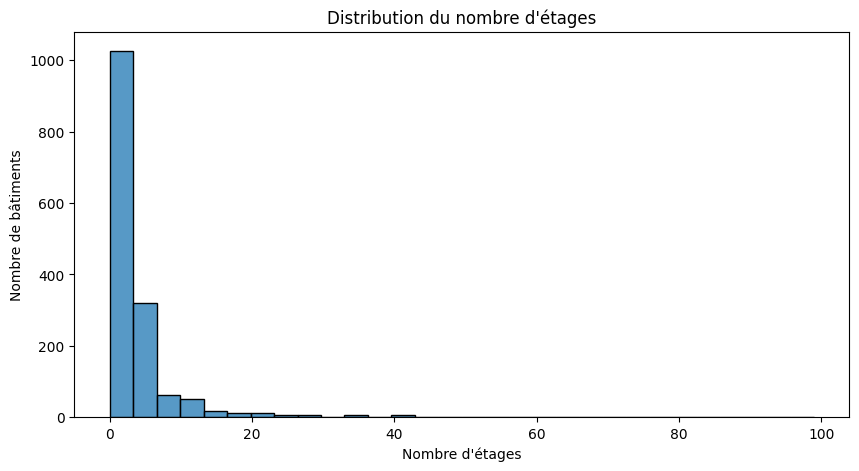

In [247]:
plt.figure(figsize=(10, 5))
sns.histplot(building_consumption["NumberofFloors"], bins=30, kde=False)
plt.title("Distribution du nombre d'étages")
plt.xlabel("Nombre d'étages")
plt.ylabel("Nombre de bâtiments")
plt.show()

In [248]:
# Correction d'un batiment avec 99 étages (Chinese Baptist Church, check effectué sur Google Maps)

building_consumption.loc[
    building_consumption["NumberofFloors"] == 99, "NumberofFloors"
] = 1

In [249]:
# Créer des quintiles pour "NumberofFloors"
# et afficher le nombre de bâtiments dans chaque quintile
building_consumption["NumberofFloors_quintile"] = pd.qcut(building_consumption["NumberofFloors"], q=5, labels=["Q1", "Q2", "Q3", "Q4", "Q5"])
print(building_consumption["NumberofFloors_quintile"].value_counts())
# Encodage se fera dans l'étape 3. Préparation des features

# Supprimer la colonne originale
building_consumption.drop(columns=["NumberofFloors"], inplace=True)

NumberofFloors_quintile
Q1    440
Q2    344
Q5    273
Q3    244
Q4    238
Name: count, dtype: int64


## 3. Nouvelles features sur les types d'énergie utilisés

### Création de variables indicatrices (0/1) pour indiquer si le bâtiment utilise ou pas chacun des types d'énergie suivants : "Electricity(kBtu)", "NaturalGas(kBtu)", "SteamUse(kBtu)". Pour cela, on crée une nouvelle colonne pour chaque type d'énergie, avec la valeur 1 si la consommation est supérieure à 0, et 0 sinon. On supprime ensuite les colonnes originales.

In [250]:
building_consumption.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'Comments', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'NumberOfUseTypes', 'NumberofFloors_quintile'],
      dtype=

In [251]:
energy_features = ["SteamUse(kBtu)", "NaturalGas(kBtu)", "Electricity(kBtu)"]
for energy in energy_features:
    building_consumption[energy.replace("(kBtu)", "").strip()] = (
        building_consumption[energy] > 0
    ).astype(int)

# Supprimer les colonnes originales
building_consumption.drop(columns=energy_features, inplace=True)
building_consumption["SteamUse"].head()

0    1
1    0
2    1
3    1
4    0
Name: SteamUse, dtype: int64

## 4. Feature à partir de YearBuilt

### Création d'intervalles de 20 ans pour la feature "YearBuilt" et suppression de la colonne originale.

In [252]:
building_consumption["YearBuilt"].describe()

count    1539.000000
mean     1961.807018
std        32.765547
min      1900.000000
25%      1930.000000
50%      1966.000000
75%      1989.000000
max      2015.000000
Name: YearBuilt, dtype: float64

In [253]:
# Supposant building_consumption a YearBuilt
bins = [0, 1930, 1950, 1970, 1990, 2010, 2025]
labels = ["≤1930", "1931-1950", "1951-1970", "1971-1990", "1991-2010", "Post-2010"]
building_consumption["EraBuilt"] = pd.cut(
    building_consumption["YearBuilt"],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True,
)
# Encodage se fera dans l'étape 3. Préparation des features

# Suppression de la variable YearBuilt
building_consumption.drop(columns=["YearBuilt"], inplace=True)

In [254]:
### Dataset post feature engineering
building_consumption.to_csv("../assets/building_consumption_post_feature_engineering.csv", index=False)